In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

exec(open("../connect_db.py").read(), globals())

In [5]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [18]:
query = session.query(Train).limit(10)
df = sql_to_df(query)
df

,week,store_id,channel_id,route_id,client_id,product_id,sales_vol,sales_val,returns_vol,returns_val,demand,id
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3,1
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4,2
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4,3
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4,4
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3,5
5,3,1110,7,3301,15766,1250,5,38.20,0,0.0,5,6
6,3,1110,7,3301,15766,1309,3,20.28,0,0.0,3,7
7,3,1110,7,3301,15766,3894,6,56.10,0,0.0,6,8
8,3,1110,7,3301,15766,4085,4,24.60,0,0.0,4,9
9,3,1110,7,3301,15766,5310,6,31.68,0,0.0,6,10


# Products

       mean_demand      n_weeks
count  1799.000000  1799.000000
mean     56.036822     6.063369
std     210.407829     1.888843
min       0.000000     1.000000
25%       3.534651     7.000000
50%       9.003126     7.000000
75%      31.118622     7.000000
max    2950.000000     7.000000


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


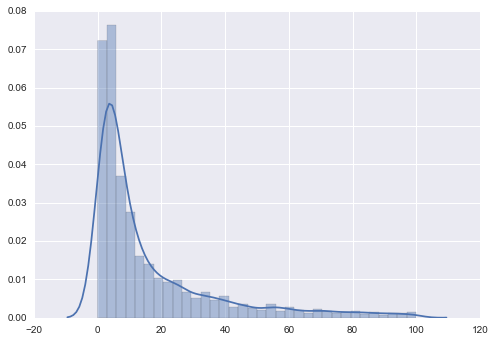

In [10]:
query = session.query(Train.product_id, 
                      func.avg(Train.demand).label('mean_demand'),
                      func.count(sql.distinct(Train.week)).label('n_weeks')).group_by(Train.product_id)
byproduct = sql_to_df(query)
print(byproduct.describe())

demand_by_prod = byproduct.query('mean_demand < 100')['mean_demand'].tolist()
sns.distplot(demand_by_prod)

* More than 75% of items are sold in each week (ie sales in 7 weeks)
* Demand for most items is low (50% of product/week/store/channel combinations have demand of <10).
* There is an extremely long tail

# Stores

In [11]:
query = session.query(Train.store_id, 
                      func.count(sql.distinct(Train.product_id)).label('products'),
                      func.avg(Train.demand).label('mean_demand')).group_by(Train.store_id)
bystore = sql_to_df(query)
print(bystore.describe())


         products  mean_demand
count  552.000000   552.000000
mean   150.269928    38.078688
std     56.915175   108.344328
min      6.000000     4.066216
25%    106.000000     6.038369
50%    159.000000    10.549237
75%    189.000000    48.160921
max    328.000000  2324.645161


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


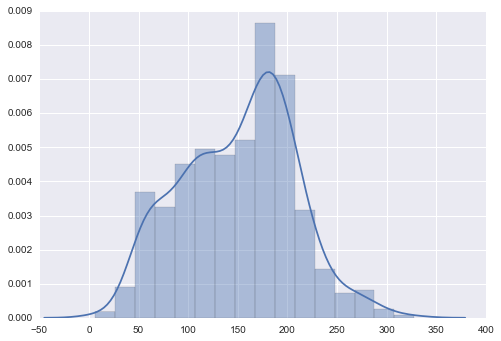

In [12]:
products_by_store = bystore['products'].tolist()
sns.distplot(products_by_store)

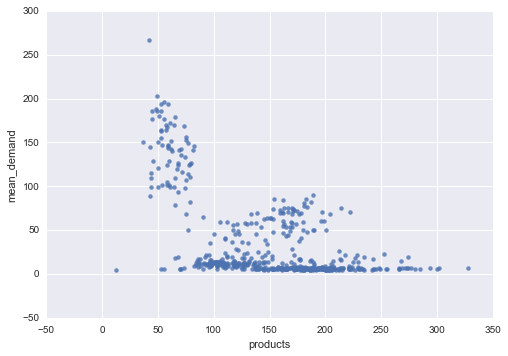

In [17]:
sns.regplot(x='products', y='mean_demand', data=bystore.query('mean_demand<1000'), fit_reg=False)

* Stores carry between 6 and 300 different products
* The larger a store is, the smaller are returns
* This is not a linear effect: Stores smaller than c 75 products are small and have much higher demand, while there are specific larger stores with elevated demands 

# Sales vs Returns

In [21]:
query = (session.query(Train.product_id, Train.week,
                      func.avg(Train.sales_vol).label('mean_sales_vol'),
                      func.avg(Train.returns_vol).label('mean_returns_vol')).
        group_by(Train.product_id, Train.week))
salesreturns = sql_to_df(query)
print(salesreturns.describe())

               week  mean_sales_vol  mean_returns_vol
count  10908.000000    10908.000000      10908.000000
mean       5.994683       50.168630         25.854287
std        2.004389      187.453146       2393.925763
min        3.000000        0.000000          0.000000
25%        4.000000        3.807090          0.016052
50%        6.000000        9.754819          0.111865
75%        8.000000       31.500000          0.750263
max        9.000000     3904.000000     250000.000000


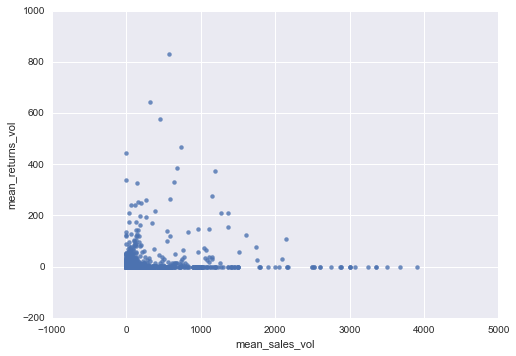

In [24]:
sns.regplot(x='mean_sales_vol', y='mean_returns_vol', data=salesreturns.query('mean_returns_vol < 1000'), fit_reg=False)